In [1]:
!echo $CONDA_PREFIX

/home/ubuntu/miniconda3/envs/jupyter_launch


In [2]:
import tensorflow as tf
from tensorflow import keras as K

import nibabel as nib
import numpy as np
import os
import datetime
from pathlib import Path

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "/home/ubuntu/brats_2018_on_intel/src/")

#import warnings
#warnings.filterwarnings("ignore")

2022-09-08 21:06:03.562096: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
def get_mkl_enabled_flag():

    mkl_enabled = False
    major_version = int(tf.__version__.split(".")[0])
    minor_version = int(tf.__version__.split(".")[1])
    if major_version >= 2:
        if minor_version < 5:
            from tensorflow.python import _pywrap_util_port
        elif minor_version >= 9:

            from tensorflow.python.util import _pywrap_util_port
            onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '1'))

        else:
            from tensorflow.python.util import _pywrap_util_port
            onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '0'))
        mkl_enabled = _pywrap_util_port.IsMklEnabled() or (onednn_enabled == 1)
    else:
        mkl_enabled = tf.pywrap_tensorflow.IsMklEnabled()
    return mkl_enabled

print ("We are using Tensorflow version", tf.__version__)
print("MKL enabled :", get_mkl_enabled_flag())

We are using Tensorflow version 2.9.1
MKL enabled : True


## Define the settings

In [9]:
!pwd

/home/ubuntu/brats_2018_on_intel/notebooks


In [10]:
DATA_PATH = "/home/ubuntu/brats_2018_on_intel/data/processed/Task01_BrainTumour/"
DATA_DIR = "/home/ubuntu/brats_2018_on_intel/data/processed/"
DATASET = "Task01_BrainTumour/"

TRAIN_TEST_SPLIT = 0.80
VALIDATE_TEST_SPLIT = 0.50

BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VALIDATE = 4
BATCH_SIZE_TEST = 1

TILE_HEIGHT = 144
TILE_WIDTH = 144
TILE_DEPTH = 144
NUMBER_INPUT_CHANNELS = 1

CROP_DIM = (TILE_HEIGHT,TILE_WIDTH,TILE_DEPTH,NUMBER_INPUT_CHANNELS)

NUMBER_OUTPUT_CLASSES = 1


MODEL_DIR = "/home/ubuntu/brats_2018_on_intel/models"
SAVED_MODEL_NAME = "3d_unet_decathlon"

FILTERS = 16
NUM_EPOCHS = 40

RANDOM_SEED = 64


## Define a data loader

We'll use `tf.data` to define a way to load the BraTS dataset at runtime whenever a new batch of 3D images and masks are requested.

In [14]:
from data.dataloader import DatasetGenerator

In [15]:
brats_datafiles = DatasetGenerator(data_dir = DATA_DIR,
                                   dataset = DATASET,
                                   data_path = DATA_PATH, 
                                   train_test_split = TRAIN_TEST_SPLIT,
                                   validate_test_split = VALIDATE_TEST_SPLIT,
                                   batch_size_train = BATCH_SIZE_TRAIN,
                                   batch_size_validate = BATCH_SIZE_VALIDATE,
                                   batch_size_test = BATCH_SIZE_TEST,
                                   tile_height = TILE_HEIGHT, 
                                   tile_width = TILE_WIDTH, 
                                   tile_depth = TILE_DEPTH, 
                                   number_input_channels = NUMBER_INPUT_CHANNELS,
                                   crop_dim = (TILE_HEIGHT, TILE_WIDTH,
                                               TILE_DEPTH, NUMBER_INPUT_CHANNELS),
                                   number_output_classes=NUMBER_OUTPUT_CLASSES,
                                   random_seed=RANDOM_SEED)
brats_datafiles.print_info()

Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Input channels:       {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
Output labels:        {'0': 'background', '1': 'edema', '2': 'non-enhancing tumor', '3': 'enhancing tumour'}
Dataset license:      CC-BY-SA 4.0


## Plot some data samples

Plots the MRI and Tumor Masks from a few data samples.

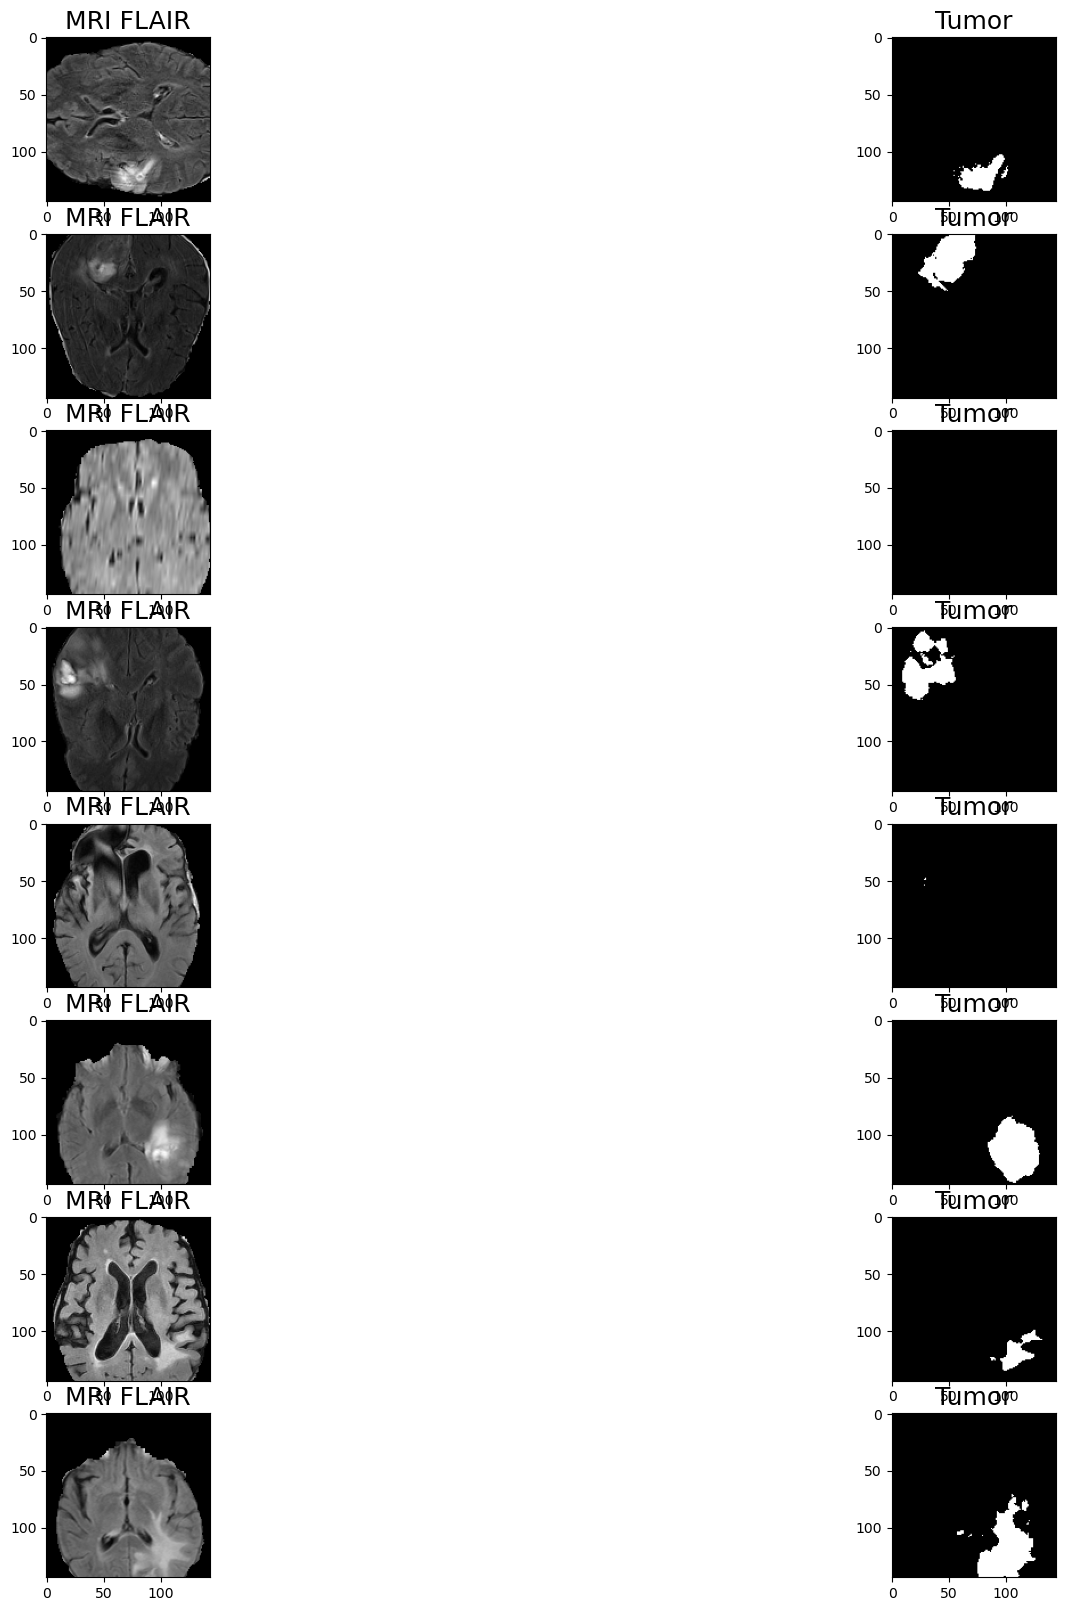

Mean pixel value of image = 3.3514325536998513e-07


In [16]:
brats_datafiles.display_train_images()

## Define the loss and metrics

In [17]:
def dice_coef(target, prediction, axis=(1, 2, 3), smooth=0.0001):
    """
    Sorenson Dice
    \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
    where T is ground truth mask and P is the prediction mask
    """
    prediction = tf.round(prediction)  # Round to 0 or 1

    intersection = tf.reduce_sum(target * prediction, axis=axis)
    union = tf.reduce_sum(target + prediction, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coef = numerator / denominator

    return tf.reduce_mean(coef)


def soft_dice_coef(target, prediction, axis=(1, 2, 3), smooth=0.0001):
    """
    Sorenson (Soft) Dice - Don't round predictions
    \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
    where T is ground truth mask and P is the prediction mask
    """
    intersection = tf.reduce_sum(target * prediction, axis=axis)
    union = tf.reduce_sum(target + prediction, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coef = numerator / denominator

    return tf.reduce_mean(coef)


def dice_loss(target, prediction, axis=(1, 2, 3), smooth=0.0001):
    """
    Sorenson (Soft) Dice loss
    Using -log(Dice) as the loss since it is better behaved.
    Also, the log allows avoidance of the division which
    can help prevent underflow when the numbers are very small.
    """
    intersection = tf.reduce_sum(prediction * target, axis=axis)
    p = tf.reduce_sum(prediction, axis=axis)
    t = tf.reduce_sum(target, axis=axis)
    numerator = tf.reduce_mean(intersection + smooth)
    denominator = tf.reduce_mean(t + p + smooth)
    dice_loss = -tf.math.log(2.*numerator) + tf.math.log(denominator)

    return dice_loss


## Define the 3D U-Net

Create a TensorFlow model.

In [18]:
def unet_3d(input_dim=CROP_DIM, 
            filters=FILTERS, 
            number_output_classes = NUMBER_OUTPUT_CLASSES,
            use_upsampling=False, 
            concat_axis=-1,
            model_name = SAVED_MODEL_NAME):
    """
    3D U-Net
    """
    
    def ConvolutionBlock(x, name, filters, params):
        """
        Convolutional block of layers
        Per the original paper this is back to back 3D convs
        with batch norm and then ReLU.
        """

        x = K.layers.Conv3D(filters=filters, **params, name=name+"_conv_0")(x)
        x = K.layers.BatchNormalization(name=name+"_bn_0")(x)
        x = K.layers.Activation("relu", name=name+"_relu_0")(x)

        x = K.layers.Conv3D(filters=filters, **params, name=name+"_conv_1")(x)
        x = K.layers.BatchNormalization(name=name+"_bn_1")(x)
        x = K.layers.Activation("relu", name=name)(x)

        return x


    # Convolution parameters
    params = dict(kernel_size=(3, 3, 3), activation=None,
                  padding="same", 
                  kernel_initializer="he_uniform")

    # Transposed convolution parameters
    params_trans = dict(kernel_size=(2, 2, 2), strides=(2, 2, 2),
                        padding="same",
                        kernel_initializer="he_uniform")

    
    inputs = K.layers.Input(shape=input_dim, name="mrimages")

    # BEGIN - Encoding path
    encode_a = ConvolutionBlock(inputs, "encode_a", filters, params)
    pool_a = K.layers.MaxPooling3D(name="pool_a", pool_size=(2, 2, 2))(encode_a)

    encode_b = ConvolutionBlock(pool_a, "encode_b", filters*2, params)
    pool_b = K.layers.MaxPooling3D(name="pool_b", pool_size=(2, 2, 2))(encode_b)

    encode_c = ConvolutionBlock(pool_b, "encode_c", filters*4, params)
    pool_c = K.layers.MaxPooling3D(name="pool_c", pool_size=(2, 2, 2))(encode_c)

    encode_d = ConvolutionBlock(pool_c, "encode_d", filters*8, params)
    pool_d = K.layers.MaxPooling3D(name="pool_d", pool_size=(2, 2, 2))(encode_d)

    encode_e = ConvolutionBlock(pool_d, "encode_e", filters*16, params)
    # END - Encoding path

    
    # BEGIN - Decoding path
    if use_upsampling:
        up = K.layers.UpSampling3D(name="up_e", size=(2, 2, 2),
                                   interpolation="bilinear")(encode_e)
    else:
        up = K.layers.Conv3DTranspose(name="transconv_e", filters=filters*8,
                                      **params_trans)(encode_e)
    concat_d = K.layers.concatenate(
        [up, encode_d], axis=concat_axis, name="concat_d")

    decode_c = ConvolutionBlock(concat_d, "decode_c", filters*8, params)

    if use_upsampling:
        up = K.layers.UpSampling3D(name="up_c", size=(2, 2, 2),
                                   interpolation="bilinear")(decode_c)
    else:
        up = K.layers.Conv3DTranspose(name="transconv_c", filters=filters*4,
                                      **params_trans)(decode_c)
    concat_c = K.layers.concatenate(
        [up, encode_c], axis=concat_axis, name="concat_c")

    decode_b = ConvolutionBlock(concat_c, "decode_b", filters*4, params)

    if use_upsampling:
        up = K.layers.UpSampling3D(name="up_b", size=(2, 2, 2),
                                   interpolation="bilinear")(decode_b)
    else:
        up = K.layers.Conv3DTranspose(name="transconv_b", filters=filters*2,
                                      **params_trans)(decode_b)
    concat_b = K.layers.concatenate(
        [up, encode_b], axis=concat_axis, name="concat_b")

    decode_a = ConvolutionBlock(concat_b, "decode_a", filters*2, params)

    if use_upsampling:
        up = K.layers.UpSampling3D(name="up_a", size=(2, 2, 2),
                                   interpolation="bilinear")(decode_a)
    else:
        up = K.layers.Conv3DTranspose(name="transconv_a", filters=filters,
                                      **params_trans)(decode_a)
    concat_a = K.layers.concatenate(
        [up, encode_a], axis=concat_axis, name="concat_a")
    
    conv_out = ConvolutionBlock(concat_a, "conv_out", filters, params)

    # END - Decoding path    

    
    prediction = K.layers.Conv3D(name="prediction_mask",
                                 filters=number_output_classes, kernel_size=(1, 1, 1),
                                 activation="sigmoid")(conv_out)

    model = K.models.Model(inputs=[inputs], outputs=[prediction], name=model_name)

    model.summary()

    return model

In [14]:
model = unet_3d(input_dim=CROP_DIM, 
            filters=FILTERS, 
            number_output_classes = NUMBER_OUTPUT_CLASSES,
            use_upsampling=False, 
            concat_axis=-1,
            model_name = SAVED_MODEL_NAME)

model.compile(optimizer="adam", loss=dice_loss, metrics=[dice_coef, soft_dice_coef])

Model: "3d_unet_decathlon"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mrimages (InputLayer)          [(None, 144, 144, 1  0           []                               
                                44, 1)]                                                           
                                                                                                  
 encode_a_conv_0 (Conv3D)       (None, 144, 144, 14  448         ['mrimages[0][0]']               
                                4, 16)                                                            
                                                                                                  
 encode_a_bn_0 (BatchNormalizat  (None, 144, 144, 14  64         ['encode_a_conv_0[0][0]']        
 ion)                           4, 16)                                            

## Define the training callbacks

This includes model checkpoints and TensorBoard logs.

In [15]:
saved_model_w_epoch = SAVED_MODEL_NAME + '_epoch_{epoch:02d}'
saved_model_w_epoch

'3d_unet_decathlon_epoch_{epoch:02d}'

In [17]:
model_path = Path(Path(MODEL_DIR) / saved_model_w_epoch)
checkpoint = K.callbacks.ModelCheckpoint(filepath=model_path,
                                         verbose=1,
                                         save_best_only=True)

# TensorBoard
logs_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_logs = K.callbacks.TensorBoard(log_dir=logs_dir)

callbacks = [checkpoint, tb_logs]


In [28]:
os.environ['TENSORBOARD_BINARY'] = '/home/ubuntu/miniconda3/envs/train_model/bin/tensorboard'

In [29]:
%load_ext tensorboard

In [30]:
%tensorboard --logdir logs 

## Train the model

In [20]:
steps_per_epoch = brats_datafiles.num_train // BATCH_SIZE_TRAIN

In [21]:
model.fit(brats_datafiles.get_train(), 
          epochs=NUM_EPOCHS, 
          steps_per_epoch=steps_per_epoch,
          validation_data=brats_datafiles.get_validate(), 
          callbacks=callbacks)

Epoch 1/40


2022-09-08 00:10:53.620322: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}

	while inferring type of node 'dice_loss/cond/output/_11'


48/48 [==============================] - ETA: 0s - loss: 1.7903 - dice_coef: 0.4769 - soft_dice_coef: 0.1686 
Epoch 1: val_loss improved from inf to 2.74188, saving model to /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_01


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_01/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_01/assets


48/48 [==============================] - 724s 15s/step - loss: 1.7903 - dice_coef: 0.4769 - soft_dice_coef: 0.1686 - val_loss: 2.7419 - val_dice_coef: 0.0646 - val_soft_dice_coef: 0.0646
Epoch 2/40
48/48 [==============================] - ETA: 0s - loss: 1.4969 - dice_coef: 0.6402 - soft_dice_coef: 0.2181 
Epoch 2: val_loss did not improve from 2.74188
48/48 [==============================] - 710s 15s/step - loss: 1.4969 - dice_coef: 0.6402 - soft_dice_coef: 0.2181 - val_loss: 3.5965 - val_dice_coef: 0.0651 - val_soft_dice_coef: 0.0323
Epoch 3/40
48/48 [==============================] - ETA: 0s - loss: 1.3040 - dice_coef: 0.6860 - soft_dice_coef: 0.2620 
Epoch 3: val_loss did not improve from 2.74188
48/48 [==============================] - 708s 15s/step - loss: 1.3040 - dice_coef: 0.6860 - soft_dice_coef: 0.2620 - val_loss: 8.4697 - val_dice_coef: 7.5853e-04 - val_soft_dice_coef: 5.4308e-04
Epoch 4/40
48/48 [==============================] - ETA: 0s - loss: 1.1211 - dice_coef: 0.7212 

INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_04/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_04/assets


48/48 [==============================] - 714s 15s/step - loss: 1.1211 - dice_coef: 0.7212 - soft_dice_coef: 0.3123 - val_loss: 1.7396 - val_dice_coef: 0.3371 - val_soft_dice_coef: 0.1788
Epoch 5/40
48/48 [==============================] - ETA: 0s - loss: 0.9503 - dice_coef: 0.7293 - soft_dice_coef: 0.3661 
Epoch 5: val_loss improved from 1.73964 to 1.47127, saving model to /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_05


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_05/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_05/assets


48/48 [==============================] - 712s 15s/step - loss: 0.9503 - dice_coef: 0.7293 - soft_dice_coef: 0.3661 - val_loss: 1.4713 - val_dice_coef: 0.3944 - val_soft_dice_coef: 0.2451
Epoch 6/40
48/48 [==============================] - ETA: 0s - loss: 0.7417 - dice_coef: 0.7679 - soft_dice_coef: 0.4440 
Epoch 6: val_loss improved from 1.47127 to 1.35825, saving model to /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_06


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_06/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_06/assets


48/48 [==============================] - 713s 15s/step - loss: 0.7417 - dice_coef: 0.7679 - soft_dice_coef: 0.4440 - val_loss: 1.3582 - val_dice_coef: 0.3819 - val_soft_dice_coef: 0.2812
Epoch 7/40
48/48 [==============================] - ETA: 0s - loss: 0.5713 - dice_coef: 0.7973 - soft_dice_coef: 0.5229 
Epoch 7: val_loss improved from 1.35825 to 1.09063, saving model to /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_07


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_07/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_07/assets


48/48 [==============================] - 715s 15s/step - loss: 0.5713 - dice_coef: 0.7973 - soft_dice_coef: 0.5229 - val_loss: 1.0906 - val_dice_coef: 0.4844 - val_soft_dice_coef: 0.3102
Epoch 8/40
48/48 [==============================] - ETA: 0s - loss: 0.4469 - dice_coef: 0.7877 - soft_dice_coef: 0.5906 
Epoch 8: val_loss improved from 1.09063 to 0.78407, saving model to /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_08


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_08/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_08/assets


48/48 [==============================] - 712s 15s/step - loss: 0.4469 - dice_coef: 0.7877 - soft_dice_coef: 0.5906 - val_loss: 0.7841 - val_dice_coef: 0.6486 - val_soft_dice_coef: 0.4537
Epoch 9/40
48/48 [==============================] - ETA: 0s - loss: 0.3584 - dice_coef: 0.8068 - soft_dice_coef: 0.6489 
Epoch 9: val_loss improved from 0.78407 to 0.61653, saving model to /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_09


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_09/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_09/assets


48/48 [==============================] - 713s 15s/step - loss: 0.3584 - dice_coef: 0.8068 - soft_dice_coef: 0.6489 - val_loss: 0.6165 - val_dice_coef: 0.6767 - val_soft_dice_coef: 0.5614
Epoch 10/40
48/48 [==============================] - ETA: 0s - loss: 0.3145 - dice_coef: 0.8065 - soft_dice_coef: 0.6800 
Epoch 10: val_loss improved from 0.61653 to 0.35397, saving model to /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_10


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_10/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_10/assets


48/48 [==============================] - 713s 15s/step - loss: 0.3145 - dice_coef: 0.8065 - soft_dice_coef: 0.6800 - val_loss: 0.3540 - val_dice_coef: 0.7442 - val_soft_dice_coef: 0.6275
Epoch 11/40
48/48 [==============================] - ETA: 0s - loss: 0.2656 - dice_coef: 0.8246 - soft_dice_coef: 0.7199 
Epoch 11: val_loss improved from 0.35397 to 0.32574, saving model to /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_11


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_11/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_11/assets


48/48 [==============================] - 714s 15s/step - loss: 0.2656 - dice_coef: 0.8246 - soft_dice_coef: 0.7199 - val_loss: 0.3257 - val_dice_coef: 0.7889 - val_soft_dice_coef: 0.6809
Epoch 12/40
48/48 [==============================] - ETA: 0s - loss: 0.2435 - dice_coef: 0.8287 - soft_dice_coef: 0.7416 
Epoch 12: val_loss improved from 0.32574 to 0.23935, saving model to /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_12


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_12/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_12/assets


48/48 [==============================] - 713s 15s/step - loss: 0.2435 - dice_coef: 0.8287 - soft_dice_coef: 0.7416 - val_loss: 0.2394 - val_dice_coef: 0.8494 - val_soft_dice_coef: 0.7441
Epoch 13/40
48/48 [==============================] - ETA: 0s - loss: 0.2356 - dice_coef: 0.8211 - soft_dice_coef: 0.7448 
Epoch 13: val_loss did not improve from 0.23935
48/48 [==============================] - 707s 15s/step - loss: 0.2356 - dice_coef: 0.8211 - soft_dice_coef: 0.7448 - val_loss: 0.2969 - val_dice_coef: 0.7992 - val_soft_dice_coef: 0.7374
Epoch 14/40
48/48 [==============================] - ETA: 0s - loss: 0.2144 - dice_coef: 0.8255 - soft_dice_coef: 0.7604 
Epoch 14: val_loss did not improve from 0.23935
48/48 [==============================] - 709s 15s/step - loss: 0.2144 - dice_coef: 0.8255 - soft_dice_coef: 0.7604 - val_loss: 0.2627 - val_dice_coef: 0.8228 - val_soft_dice_coef: 0.7508
Epoch 15/40
48/48 [==============================] - ETA: 0s - loss: 0.2038 - dice_coef: 0.8332 - s

INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_15/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_15/assets


48/48 [==============================] - 711s 15s/step - loss: 0.2038 - dice_coef: 0.8332 - soft_dice_coef: 0.7799 - val_loss: 0.1974 - val_dice_coef: 0.8579 - val_soft_dice_coef: 0.7914
Epoch 16/40
48/48 [==============================] - ETA: 0s - loss: 0.2031 - dice_coef: 0.8286 - soft_dice_coef: 0.7789 
Epoch 16: val_loss did not improve from 0.19740
48/48 [==============================] - 707s 15s/step - loss: 0.2031 - dice_coef: 0.8286 - soft_dice_coef: 0.7789 - val_loss: 1.9196 - val_dice_coef: 0.1861 - val_soft_dice_coef: 0.1769
Epoch 17/40
48/48 [==============================] - ETA: 0s - loss: 0.1827 - dice_coef: 0.8432 - soft_dice_coef: 0.7999 
Epoch 17: val_loss did not improve from 0.19740
48/48 [==============================] - 709s 15s/step - loss: 0.1827 - dice_coef: 0.8432 - soft_dice_coef: 0.7999 - val_loss: 0.2482 - val_dice_coef: 0.7177 - val_soft_dice_coef: 0.6724
Epoch 18/40
48/48 [==============================] - ETA: 0s - loss: 0.1886 - dice_coef: 0.8352 - s

INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_19/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_19/assets


48/48 [==============================] - 714s 15s/step - loss: 0.1746 - dice_coef: 0.8448 - soft_dice_coef: 0.8116 - val_loss: 0.1852 - val_dice_coef: 0.8385 - val_soft_dice_coef: 0.8072
Epoch 20/40
48/48 [==============================] - ETA: 0s - loss: 0.1618 - dice_coef: 0.8535 - soft_dice_coef: 0.8226 
Epoch 20: val_loss improved from 0.18518 to 0.16914, saving model to /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_20


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_20/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_20/assets


48/48 [==============================] - 712s 15s/step - loss: 0.1618 - dice_coef: 0.8535 - soft_dice_coef: 0.8226 - val_loss: 0.1691 - val_dice_coef: 0.8599 - val_soft_dice_coef: 0.8281
Epoch 21/40
48/48 [==============================] - ETA: 0s - loss: 0.1663 - dice_coef: 0.8464 - soft_dice_coef: 0.8183 
Epoch 21: val_loss did not improve from 0.16914
48/48 [==============================] - 707s 15s/step - loss: 0.1663 - dice_coef: 0.8464 - soft_dice_coef: 0.8183 - val_loss: 0.2773 - val_dice_coef: 0.7784 - val_soft_dice_coef: 0.7584
Epoch 22/40
48/48 [==============================] - ETA: 0s - loss: 0.1639 - dice_coef: 0.8470 - soft_dice_coef: 0.8223 
Epoch 22: val_loss did not improve from 0.16914
48/48 [==============================] - 708s 15s/step - loss: 0.1639 - dice_coef: 0.8470 - soft_dice_coef: 0.8223 - val_loss: 0.4281 - val_dice_coef: 0.6480 - val_soft_dice_coef: 0.6211
Epoch 23/40
48/48 [==============================] - ETA: 0s - loss: 0.1577 - dice_coef: 0.8409 - s

INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_26/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_26/assets


48/48 [==============================] - 711s 15s/step - loss: 0.1433 - dice_coef: 0.8571 - soft_dice_coef: 0.8394 - val_loss: 0.1414 - val_dice_coef: 0.8571 - val_soft_dice_coef: 0.8384
Epoch 27/40
48/48 [==============================] - ETA: 0s - loss: 0.1455 - dice_coef: 0.8528 - soft_dice_coef: 0.8361 
Epoch 27: val_loss improved from 0.14137 to 0.13159, saving model to /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_27


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_27/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_27/assets


48/48 [==============================] - 712s 15s/step - loss: 0.1455 - dice_coef: 0.8528 - soft_dice_coef: 0.8361 - val_loss: 0.1316 - val_dice_coef: 0.8729 - val_soft_dice_coef: 0.8565
Epoch 28/40
48/48 [==============================] - ETA: 0s - loss: 0.1560 - dice_coef: 0.8424 - soft_dice_coef: 0.8270 
Epoch 28: val_loss did not improve from 0.13159
48/48 [==============================] - 709s 15s/step - loss: 0.1560 - dice_coef: 0.8424 - soft_dice_coef: 0.8270 - val_loss: 0.1336 - val_dice_coef: 0.8656 - val_soft_dice_coef: 0.8502
Epoch 29/40
48/48 [==============================] - ETA: 0s - loss: 0.1505 - dice_coef: 0.8440 - soft_dice_coef: 0.8314 
Epoch 29: val_loss did not improve from 0.13159
48/48 [==============================] - 709s 15s/step - loss: 0.1505 - dice_coef: 0.8440 - soft_dice_coef: 0.8314 - val_loss: 0.2623 - val_dice_coef: 0.7499 - val_soft_dice_coef: 0.7352
Epoch 30/40
48/48 [==============================] - ETA: 0s - loss: 0.1467 - dice_coef: 0.8528 - s

INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_37/assets


INFO:tensorflow:Assets written to: /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_37/assets


48/48 [==============================] - 712s 15s/step - loss: 0.1213 - dice_coef: 0.8731 - soft_dice_coef: 0.8644 - val_loss: 0.1280 - val_dice_coef: 0.8667 - val_soft_dice_coef: 0.8554
Epoch 38/40
48/48 [==============================] - ETA: 0s - loss: 0.1312 - dice_coef: 0.8584 - soft_dice_coef: 0.8508 
Epoch 38: val_loss did not improve from 0.12800
48/48 [==============================] - 708s 15s/step - loss: 0.1312 - dice_coef: 0.8584 - soft_dice_coef: 0.8508 - val_loss: 0.1599 - val_dice_coef: 0.8525 - val_soft_dice_coef: 0.8402
Epoch 39/40
48/48 [==============================] - ETA: 0s - loss: 0.1332 - dice_coef: 0.8618 - soft_dice_coef: 0.8538 
Epoch 39: val_loss did not improve from 0.12800
48/48 [==============================] - 707s 15s/step - loss: 0.1332 - dice_coef: 0.8618 - soft_dice_coef: 0.8538 - val_loss: 0.1699 - val_dice_coef: 0.8338 - val_soft_dice_coef: 0.8266
Epoch 40/40
48/48 [==============================] - ETA: 0s - loss: 0.1494 - dice_coef: 0.8426 - s

## Evaluate the model

Evaluate the final model on the test dataset. This gives us an idea of how the model should perform on data it has never seen.

In [22]:
test_loss, test_dice_coef, test_soft_dice_coef = model.evaluate(brats_datafiles.get_test())

print("Average Dice Coefficient on test dataset = {:.4f}".format(test_dice_coef))

49/49 [==============================] - 41s 769ms/step - loss: 1.0422 - dice_coef: 0.5935 - soft_dice_coef: 0.5909
Average Dice Coefficient on test dataset = 0.5935


In [23]:
save_path = Path(Path(MODEL_DIR) / Path(SAVED_MODEL_NAME) / SAVED_MODEL_NAME).with_suffix(".h5")
model.save(save_path)

In [24]:
print(f'Absolute path where the base tf model in fp32 precisions is saved:\n {save_path.resolve()}')

Absolute path where the base tf model in fp32 precisions is saved:
 /home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon/3d_unet_decathlon.h5


In [40]:
selected_model_epoch = 27

selected_model_name = SAVED_MODEL_NAME + "_epoch_" + str(selected_model_epoch)
selected_model_path = str(Path(Path(MODEL_DIR) / Path(selected_model_name)))
selected_model_save_path = Path(Path(selected_model_path) / Path(selected_model_name)).with_suffix(".h5")
selected_model_save_path

PosixPath('/home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_27/3d_unet_decathlon_epoch_27.h5')

In [41]:
tf_model = tf.keras.models.load_model(selected_model_path, 
                                      compile=True, 
                                      custom_objects={"dice_coef":dice_coef, "soft_dice_coef":soft_dice_coef, "dice_loss":dice_loss})

In [42]:
tf_model.save(selected_model_save_path)